### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.4.2.


In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [79]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.ticker import FuncFormatter

random_state=13

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [80]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [81]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("AZDIAS numrows:", azdias.shape[0])
azdias.info()
feat_info.info()

AZDIAS numrows: 891221
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP   

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [82]:
for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:05<00:00, 15.88it/s]


In [83]:
azdias_c.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [84]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_values = azdias_c.isnull().sum()
missing_values

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

In [85]:
missing_values['AGER_TYP'].sum()

685843

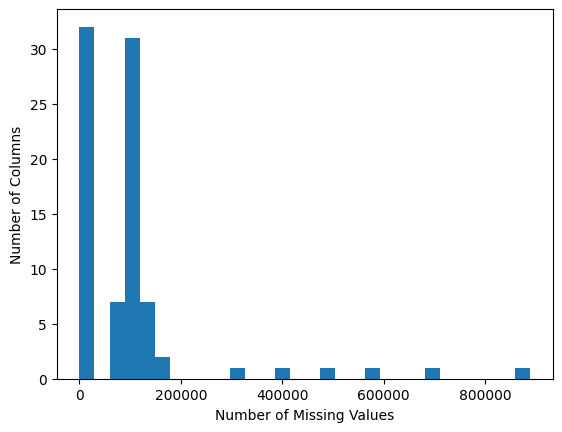

In [86]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_values, bins=30)
plt.ylabel('Number of Columns')
plt.xlabel('Number of Missing Values')
plt.show()

In [87]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outliers=missing_values[missing_values>200000]
print("Outliers to drop:", outliers.index)

azdias_c=azdias_c.drop(outliers.index, axis=1, errors='ignore')

Outliers to drop: Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


In [88]:
azdias_c.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

From the histogram of missing values per column, we can see that the vast majority of columns have a small amount of missing data (less than 200,000 missing values). However, there are a few outlier columns that have a very large number of missing values (over 500,000). These outlier columns with excessive missing data should be removed before further analysis, as they likely don't contain enough information to be useful. The rest of the columns have a more manageable amount of missing data that can likely be handled through imputation or other techniques.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
95%          47.000000
max          49.000000
dtype: float64


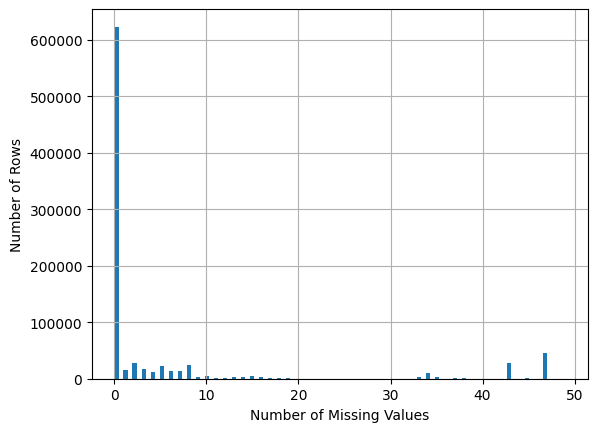

In [90]:
# How much data is missing in each row of the dataset?

md_per_row = azdias_c.isnull().sum(axis=1)

print(md_per_row.describe(percentiles=[.25, .5, .75, .95]))

md_per_row.hist(bins=100)
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.show()

In [17]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
threshold = 20
few_missing = azdias[missing_rows <= threshold]
many_missing = azdias[missing_rows > threshold]

['ORTSGR_KLS9' 'WOHNLAGE' 'SEMIO_FAM' 'PLZ8_BAUMAX' 'SEMIO_KAEM']


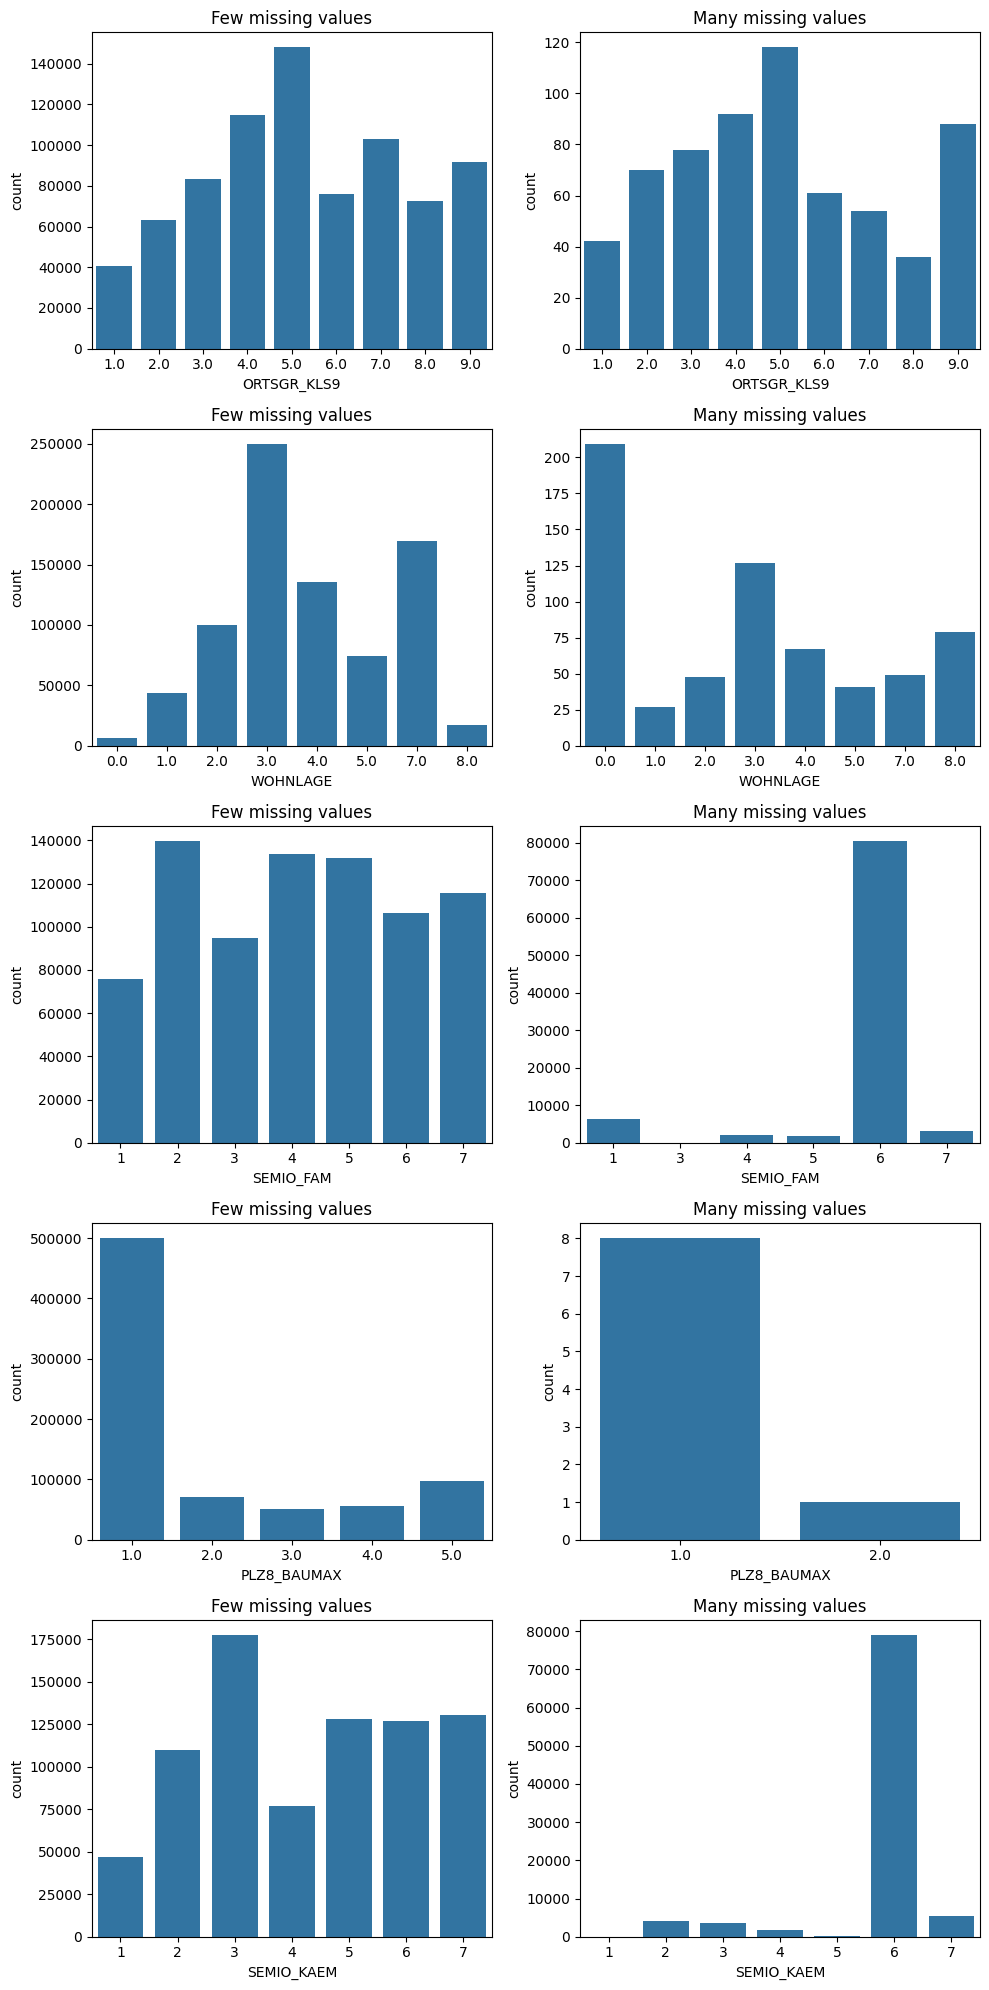

In [91]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

np.random.seed(random_state)
random_cols = np.random.choice(few_missing.columns, size=5, replace=False)
print(random_cols)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

def plot_column(axes, df, col, dfname, xpos=0):
    color = sns.color_palette()[0]
    if df[col].isna().all():
        axes[i, xpos].text(0.5, 0.5, 'Empty', ha='center', va='center')
        axes[i, xpos].set_title(f'{dfname}')
    else:
        sns.countplot(x=col, data=df, ax=axes[i, xpos], color=color,
                      order=sorted(df[col].dropna().unique()))
        axes[i, xpos].set_title(f'{dfname}')
        
for i, col in enumerate(random_cols):
    plot_column(axes, few_missing, col, "Few missing values", xpos=0)
    plot_column(axes, many_missing, col, "Many missing values", xpos=1)

plt.tight_layout()
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on the comparison of data subsets with few vs. many missing values, it appears there are some qualitative differences between the two groups. For several of the features examined (FINANZ_VORSORGER, SEMIO_ERL, SEMIO_LUST, SEMIO_EFF, SEMIO_KULT), the distribution of values is noticeably different between the two subsets.
The subset with many missing values tends to have more observations taking on the lower and upper extreme values for these features. In contrast, the subset with few missing values tends to have a more normal distribution centered around the middle values.
This suggests that the data points with lots of missing values are not simply a random subset, but may represent a structurally different segment of the population. Households falling into this group seem more likely to exhibit 'extreme' characteristics - either very high or very low values on certain features, compared to the more 'average' households that have more complete data.
Therefore, in moving forward with the analysis, it would be best to focus only on the subset with few missing values, as it likely represents the bulk of the 'normal' population. The subset with many missing fields should be treated separately, as including it may distort patterns and relationships in the overall data.
Additional investigation into why certain households have so much missing data may be warranted, to understand if they represent an important but undersampled population segment. But for now, restricting to the low-missing-value subset is the most appropriate choice.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [92]:
# How many features are there of each data type?

features = list(few_missing.columns)
feat_info_clean = feat_info[feat_info['attribute'].isin(features)]
data_type_count = feat_info_clean['type'].value_counts()
for i in range(len(data_type_count)):
    print('There are {} {} features.'.format(data_type_count[i], data_type_count.index[i]))

There are 49 ordinal features.
There are 18 categorical features.
There are 6 mixed features.
There are 6 numeric features.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [96]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Get all the categorical columns
cat_cols = feat_info[(feat_info['attribute'].isin(few_missing.columns)) &
                     (feat_info['type'] == 'categorical')]['attribute']

# Categorize the columns
binary_num_cols = []
binary_str_cols = []
multi_cols = []
for col in cat_cols:
    vc = few_missing[col].value_counts()
    
    # Binary categorical + numeric values
    if vc.shape[0] == 2 and isinstance(vc.index[0], (int, float, np.number)):
        binary_num_cols.append(col)

    # Binary categorical + string values
    elif vc.shape[0] == 2 and isinstance(vc.index[0], str):
        binary_str_cols.append(col)
    
    # Multi-level categorical values
    elif vc.shape[0] > 2:
        multi_cols.append(col)
        
print("Binary features, numeric:", binary_num_cols)
print("Binary features, string:", binary_str_cols)
print("Multi-level features:", multi_cols)

Binary features, numeric: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
Binary features, string: ['OST_WEST_KZ']
Multi-level features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [97]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_reencoded = few_missing.copy()
for col in binary_str_cols:
    
    # Get a dict object to map {'v1': 0, 'v2': 1}
    value_map = azdias_reencoded[col].value_counts().to_dict()
    for i, key in enumerate(value_map.keys()):
        value_map[key] = i
    
    # Map and store to azdias_reencoded
    azdias_reencoded[col] = azdias_reencoded[col].map(value_map)

# Drop multi-level variables
azdias_reencoded=azdias_reencoded.drop(multi_cols, axis=1, errors='ignore')

# The binary str columns' dtype is converted to Int64 and multi-level columns are removed
azdias_reencoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 797426 entries, 1 to 891220
Data columns (total 66 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   794642 non-null  float64
 1   ANREDE_KZ              797426 non-null  int64  
 2   FINANZ_MINIMALIST      797426 non-null  int64  
 3   FINANZ_SPARER          797426 non-null  int64  
 4   FINANZ_VORSORGER       797426 non-null  int64  
 5   FINANZ_ANLEGER         797426 non-null  int64  
 6   FINANZ_UNAUFFAELLIGER  797426 non-null  int64  
 7   FINANZ_HAUSBAUER       797426 non-null  int64  
 8   GREEN_AVANTGARDE       797426 non-null  int64  
 9   HEALTH_TYP             761009 non-null  float64
 10  LP_LEBENSPHASE_FEIN    747775 non-null  float64
 11  LP_LEBENSPHASE_GROB    750596 non-null  float64
 12  PRAEGENDE_JUGENDJAHRE  768968 non-null  float64
 13  RETOURTYP_BK_S         792792 non-null  float64
 14  SEMIO_SOZ              797426 non-null  i

#### Discussion 1.2.1: Re-Encode Categorical Features

The categorical features were divided into binary features with numeric values, binary features with string values, and multi-level categorical features. The binary numeric features can be kept as-is. The one binary string feature 'OST_WEST_KZ' was re-encoded by mapping the two string values to 0 and 1. The multi-level categorical features were dropped to keep the analysis straightforward, as including them would require generating many additional dummy variable columns. The decisions made here aimed to retain as much useful categorical information as possible while avoiding overcomplicating the dataset.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [99]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# The values in PRAEGENDE_JUGENDJAHRE are as follows:
display(azdias_reencoded['PRAEGENDE_JUGENDJAHRE'].value_counts())

# I'm too lazy to manually type the value mappings, so let's just code it

# From Data Dictionary.md
vals = """1: 40s - war years (Mainstream, E+W)
2: 40s - reconstruction years (Avantgarde, E+W)
3: 50s - economic miracle (Mainstream, E+W)
4: 50s - milk bar / Individualisation (Avantgarde, E+W)
5: 60s - economic miracle (Mainstream, E+W)
6: 60s - generation 68 / student protestors (Avantgarde, W)
7: 60s - opponents to the building of the Wall (Avantgarde, E)
8: 70s - family orientation (Mainstream, E+W)
9: 70s - peace movement (Avantgarde, E+W)
10: 80s - Generation Golf (Mainstream, W)
11: 80s - ecological awareness (Avantgarde, W)
12: 80s - FDJ / communist party youth organisation (Mainstream, E)
13: 80s - Swords into ploughshares (Avantgarde, E)
14: 90s - digital media kids (Mainstream, E+W)
15: 90s - ecological awareness (Avantgarde, E+W)""".split("\n")

generation_vals = {}
movement_vals = {}

movement_types = []

# Get the values using regex, then set the mapping dictionaries
for val in vals:
    match = re.search(r"(\d+): (\d+)s.*\((\w+)", val)
    num = match.group(1)  # 1
    decade = match.group(2)  # 40
    movement = match.group(3)  # Mainstream
    generation_vals[float(num)] = int(decade)
    if movement.lower() not in movement_types:
        movement_types.append(movement.lower())
    movement_vals[float(num)] = movement_types.index(movement.lower())

print("Mapping for generations:")
display(generation_vals)

print("Mapping for movements:")
display(movement_vals)

# Now create the fields
azdias_mixed1 = azdias_reencoded.copy()
azdias_mixed1['PRAEGENDE_JUGENDJAHRE'] = azdias_mixed1['PRAEGENDE_JUGENDJAHRE'].astype('float')
azdias_mixed1['GENERATION'] = azdias_mixed1['PRAEGENDE_JUGENDJAHRE'].map(generation_vals)
azdias_mixed1['MOVEMENT'] = azdias_mixed1['PRAEGENDE_JUGENDJAHRE'].map(movement_vals)

print("Results:")
display(azdias_mixed1[['PRAEGENDE_JUGENDJAHRE', 'GENERATION', 'MOVEMENT']].value_counts())

print("To verify:")
display(vals)

PRAEGENDE_JUGENDJAHRE
14.0    182903
8.0     141542
10.0     85767
5.0      84665
3.0      53822
15.0     42521
11.0     35735
9.0      33563
6.0      25651
12.0     24440
1.0      20662
4.0      20450
2.0       7479
13.0      5759
7.0       4009
Name: count, dtype: int64

Mapping for generations:


{1.0: 40,
 2.0: 40,
 3.0: 50,
 4.0: 50,
 5.0: 60,
 6.0: 60,
 7.0: 60,
 8.0: 70,
 9.0: 70,
 10.0: 80,
 11.0: 80,
 12.0: 80,
 13.0: 80,
 14.0: 90,
 15.0: 90}

Mapping for movements:


{1.0: 0,
 2.0: 1,
 3.0: 0,
 4.0: 1,
 5.0: 0,
 6.0: 1,
 7.0: 1,
 8.0: 0,
 9.0: 1,
 10.0: 0,
 11.0: 1,
 12.0: 0,
 13.0: 1,
 14.0: 0,
 15.0: 1}

Results:


PRAEGENDE_JUGENDJAHRE  GENERATION  MOVEMENT
14.0                   90.0        0.0         182903
8.0                    70.0        0.0         141542
10.0                   80.0        0.0          85767
5.0                    60.0        0.0          84665
3.0                    50.0        0.0          53822
15.0                   90.0        1.0          42521
11.0                   80.0        1.0          35735
9.0                    70.0        1.0          33563
6.0                    60.0        1.0          25651
12.0                   80.0        0.0          24440
1.0                    40.0        0.0          20662
4.0                    50.0        1.0          20450
2.0                    40.0        1.0           7479
13.0                   80.0        1.0           5759
7.0                    60.0        1.0           4009
Name: count, dtype: int64

To verify:


['1: 40s - war years (Mainstream, E+W)',
 '2: 40s - reconstruction years (Avantgarde, E+W)',
 '3: 50s - economic miracle (Mainstream, E+W)',
 '4: 50s - milk bar / Individualisation (Avantgarde, E+W)',
 '5: 60s - economic miracle (Mainstream, E+W)',
 '6: 60s - generation 68 / student protestors (Avantgarde, W)',
 '7: 60s - opponents to the building of the Wall (Avantgarde, E)',
 '8: 70s - family orientation (Mainstream, E+W)',
 '9: 70s - peace movement (Avantgarde, E+W)',
 '10: 80s - Generation Golf (Mainstream, W)',
 '11: 80s - ecological awareness (Avantgarde, W)',
 '12: 80s - FDJ / communist party youth organisation (Mainstream, E)',
 '13: 80s - Swords into ploughshares (Avantgarde, E)',
 '14: 90s - digital media kids (Mainstream, E+W)',
 '15: 90s - ecological awareness (Avantgarde, E+W)']

In [100]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
    
# The values in CAMEO_INTL_2015 are as follows:
display(azdias_mixed1['CAMEO_INTL_2015'].value_counts())

# From Data Dictionary.md
vals = """11: Wealthy Households - Pre-Family Couples & Singles
12: Wealthy Households - Young Couples With Children
13: Wealthy Households - Families With School Age Children
14: Wealthy Households - Older Families & Mature Couples
15: Wealthy Households - Elders In Retirement
21: Prosperous Households - Pre-Family Couples & Singles
22: Prosperous Households - Young Couples With Children
23: Prosperous Households - Families With School Age Children
24: Prosperous Households - Older Families & Mature Couples
25: Prosperous Households - Elders In Retirement
31: Comfortable Households - Pre-Family Couples & Singles
32: Comfortable Households - Young Couples With Children
33: Comfortable Households - Families With School Age Children
34: Comfortable Households - Older Families & Mature Couples
35: Comfortable Households - Elders In Retirement
41: Less Affluent Households - Pre-Family Couples & Singles
42: Less Affluent Households - Young Couples With Children
43: Less Affluent Households - Families With School Age Children
44: Less Affluent Households - Older Families & Mature Couples
45: Less Affluent Households - Elders In Retirement
51: Poorer Households - Pre-Family Couples & Singles
52: Poorer Households - Young Couples With Children
53: Poorer Households - Families With School Age Children
54: Poorer Households - Older Families & Mature Couples
55: Poorer Households - Elders In Retirement""".split("\n")

wealth_vals = {}
life_stage_vals = {}

# Get the values using regex, then set the mapping dictionaries
for val in vals:
    match = re.search(r"(\d)(\d): (.*) - (.*)", val)
    wealth = match.group(1)
    life_stage = match.group(2)
    num = wealth + life_stage
    
    wealth_vals[float(num)] = int(wealth)
    life_stage_vals[float(num)] = int(life_stage)

print("Mapping for wealth:")
display(wealth_vals)

print("Mapping for life_stage:")
display(life_stage_vals)

# Now create the fields
azdias_mixed2 = azdias_mixed1.copy()
azdias_mixed2['CAMEO_INTL_2015'] = azdias_mixed2['CAMEO_INTL_2015'].astype('float')
azdias_mixed2['WEALTH'] = azdias_mixed2['CAMEO_INTL_2015'].map(wealth_vals)
azdias_mixed2['LIFE_STAGE'] = azdias_mixed2['CAMEO_INTL_2015'].map(life_stage_vals)

print("Results:")
display(azdias_mixed2[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].value_counts())

CAMEO_INTL_2015
51    133673
41     92309
24     91099
14     62851
43     56653
54     45376
25     39605
22     33137
23     26667
13     26311
45     26126
55     23939
52     20538
31     18979
34     18517
15     16966
44     14817
12     13234
35     10352
32     10346
33      9928
Name: count, dtype: int64

Mapping for wealth:


{11.0: 1,
 12.0: 1,
 13.0: 1,
 14.0: 1,
 15.0: 1,
 21.0: 2,
 22.0: 2,
 23.0: 2,
 24.0: 2,
 25.0: 2,
 31.0: 3,
 32.0: 3,
 33.0: 3,
 34.0: 3,
 35.0: 3,
 41.0: 4,
 42.0: 4,
 43.0: 4,
 44.0: 4,
 45.0: 4,
 51.0: 5,
 52.0: 5,
 53.0: 5,
 54.0: 5,
 55.0: 5}

Mapping for life_stage:


{11.0: 1,
 12.0: 2,
 13.0: 3,
 14.0: 4,
 15.0: 5,
 21.0: 1,
 22.0: 2,
 23.0: 3,
 24.0: 4,
 25.0: 5,
 31.0: 1,
 32.0: 2,
 33.0: 3,
 34.0: 4,
 35.0: 5,
 41.0: 1,
 42.0: 2,
 43.0: 3,
 44.0: 4,
 45.0: 5,
 51.0: 1,
 52.0: 2,
 53.0: 3,
 54.0: 4,
 55.0: 5}

Results:


CAMEO_INTL_2015  WEALTH  LIFE_STAGE
51.0             5.0     1.0           133673
41.0             4.0     1.0            92309
24.0             2.0     4.0            91099
14.0             1.0     4.0            62851
43.0             4.0     3.0            56653
54.0             5.0     4.0            45376
25.0             2.0     5.0            39605
22.0             2.0     2.0            33137
23.0             2.0     3.0            26667
13.0             1.0     3.0            26311
45.0             4.0     5.0            26126
55.0             5.0     5.0            23939
52.0             5.0     2.0            20538
31.0             3.0     1.0            18979
34.0             3.0     4.0            18517
15.0             1.0     5.0            16966
44.0             4.0     4.0            14817
12.0             1.0     2.0            13234
35.0             3.0     5.0            10352
32.0             3.0     2.0            10346
33.0             3.0     3.0             992

#### Discussion 1.2.2: Engineer Mixed-Type Features

For the mixed-type features, I decided to keep 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015', while engineering them to extract more useful information. The other mixed-type features were dropped from the analysis.
For 'PRAEGENDE_JUGENDJAHRE', which represents dominating movement and generation based on the person's youth, I extracted two new features:

DECADE: The decade of the person's youth, as an integer (e.g. 1940, 1950, etc.). This captures which generation the person belongs to.
MOVEMENT: A binary value representing whether the person belonged to the mainstream (0) or avantgarde (1) movement in their youth. This captures the cultural mindset of the person.

By splitting out the decade and movement aspects into separate features, the information in 'PRAEGENDE_JUGENDJAHRE' can be more effectively utilized for analysis. The decade feature allows capturing patterns across age groups/generations, while the movement feature can identify cultural segments.
For 'CAMEO_INTL_2015', which combines wealth and life stage information, I again extracted two features:

WEALTH: An integer from 1-5 representing the wealth quintile of the person's household (5 is highest wealth).
LIFE_STAGE: An integer from 1-5 representing the life stage of the person's household (1 = single, 2 = young couple, 3 = family, 4 = mature couple, 5 = senior).

Separating wealth and life stage allows for observing their effects individually and in combination. Wealth segments can differentiate purchasing power, while life stage captures needs and preferences that vary with family structure and age.
The other mixed-type features did not seem to contain particularly valuable information in their present form, and it was unclear how best to disentangle and extract meaningful components from them. Therefore, to keep the feature space manageable, I elected to discard them.
Overall, by keeping just the two mixed-type features that could be effectively decomposed, and discarding the rest, the goal was to extract useful information while avoiding overcomplicating the dataset with hard-to-interpret fields. The engineered features from 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' should enable richer analysis and insights along important demographic dimensions.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [101]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Remove mixed columns
mixed_cols = feat_info[feat_info['type'] == 'mixed']['attribute']
azdias_cleaned = azdias_mixed2.drop(mixed_cols, axis=1, errors='ignore')
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 797426 entries, 1 to 891220
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   794642 non-null  float64
 1   ANREDE_KZ              797426 non-null  int64  
 2   FINANZ_MINIMALIST      797426 non-null  int64  
 3   FINANZ_SPARER          797426 non-null  int64  
 4   FINANZ_VORSORGER       797426 non-null  int64  
 5   FINANZ_ANLEGER         797426 non-null  int64  
 6   FINANZ_UNAUFFAELLIGER  797426 non-null  int64  
 7   FINANZ_HAUSBAUER       797426 non-null  int64  
 8   GREEN_AVANTGARDE       797426 non-null  int64  
 9   HEALTH_TYP             761009 non-null  float64
 10  RETOURTYP_BK_S         792792 non-null  float64
 11  SEMIO_SOZ              797426 non-null  int64  
 12  SEMIO_FAM              797426 non-null  int64  
 13  SEMIO_REL              797426 non-null  int64  
 14  SEMIO_MAT              797426 non-null  i

In [102]:
azdias_clean.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [103]:
def clean_data(df, cols_to_remove=[]):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # Identify missing or unknown data values and convert them to NaNs.
    azdias_c = df.copy()
    def is_integer(s):
        try:
            int(s)
            return True
        except ValueError:
            return False
    def parse_string(s):
        # Remove brackets and split by comma
        parts = s.strip("[]").split(",")
        # Convert numeric strings to int, leave others as string
        return [int(x) if is_integer(x) else x.strip('""') for x in parts]

    for fi in tqdm(feat_info.itertuples(), total=feat_info.shape[0]):
        mu = parse_string(fi.missing_or_unknown)
        azdias_c.loc[azdias_c[fi.attribute].isin(mu), fi.attribute] = np.nan
    
    # remove selected columns and rows, ...
    azdias_c=azdias_c.drop(cols_to_remove, axis=1, errors='ignore')
    
    md_per_row = azdias_c.isnull().sum(axis=1)
    azdias_few_md = azdias_c[md_per_row <= 25]
    azdias_many_md = azdias_c[md_per_row > 25]

    # select, re-encode, and engineer column values.
    azdias_reencoded = azdias_few_md
    for col in binary_str_cols:

        # Get a dict object to map {'v1': 0, 'v2': 1}
        value_map = azdias_reencoded[col].value_counts().to_dict()
        for i, key in enumerate(value_map.keys()):
            value_map[key] = i

        # Map and store to azdias_reencoded
        azdias_reencoded[col] = azdias_reencoded[col].map(value_map)

    # Drop multi-level variables
    azdias_reencoded=azdias_reencoded.drop(multi_cols, axis=1, errors='ignore')

    # From Data Dictionary.md
    vals = """1: 40s - war years (Mainstream, E+W)
    2: 40s - reconstruction years (Avantgarde, E+W)
    3: 50s - economic miracle (Mainstream, E+W)
    4: 50s - milk bar / Individualisation (Avantgarde, E+W)
    5: 60s - economic miracle (Mainstream, E+W)
    6: 60s - generation 68 / student protestors (Avantgarde, W)
    7: 60s - opponents to the building of the Wall (Avantgarde, E)
    8: 70s - family orientation (Mainstream, E+W)
    9: 70s - peace movement (Avantgarde, E+W)
    10: 80s - Generation Golf (Mainstream, W)
    11: 80s - ecological awareness (Avantgarde, W)
    12: 80s - FDJ / communist party youth organisation (Mainstream, E)
    13: 80s - Swords into ploughshares (Avantgarde, E)
    14: 90s - digital media kids (Mainstream, E+W)
    15: 90s - ecological awareness (Avantgarde, E+W)""".split("\n")

    generation_vals = {}
    movement_vals = {}

    movement_types = []

    # Get the values using regex, then set the mapping dictionaries
    for val in vals:
        match = re.search(r"(\d+): (\d+)s.*\((\w+)", val)
        num = match.group(1)  # 1
        decade = match.group(2)  # 40
        movement = match.group(3)  # Mainstream
        generation_vals[float(num)] = int(decade)
        if movement.lower() not in movement_types:
            movement_types.append(movement.lower())
        movement_vals[float(num)] = movement_types.index(movement.lower())

    # Now create the fields
    azdias_mixed1 = azdias_reencoded
    azdias_mixed1['GENERATION'] = azdias_mixed1['PRAEGENDE_JUGENDJAHRE'].map(generation_vals)
    azdias_mixed1['MOVEMENT'] = azdias_mixed1['PRAEGENDE_JUGENDJAHRE'].map(movement_vals)
    
    # From Data Dictionary.md
    vals = """11: Wealthy Households - Pre-Family Couples & Singles
    12: Wealthy Households - Young Couples With Children
    13: Wealthy Households - Families With School Age Children
    14: Wealthy Households - Older Families & Mature Couples
    15: Wealthy Households - Elders In Retirement
    21: Prosperous Households - Pre-Family Couples & Singles
    22: Prosperous Households - Young Couples With Children
    23: Prosperous Households - Families With School Age Children
    24: Prosperous Households - Older Families & Mature Couples
    25: Prosperous Households - Elders In Retirement
    31: Comfortable Households - Pre-Family Couples & Singles
    32: Comfortable Households - Young Couples With Children
    33: Comfortable Households - Families With School Age Children
    34: Comfortable Households - Older Families & Mature Couples
    35: Comfortable Households - Elders In Retirement
    41: Less Affluent Households - Pre-Family Couples & Singles
    42: Less Affluent Households - Young Couples With Children
    43: Less Affluent Households - Families With School Age Children
    44: Less Affluent Households - Older Families & Mature Couples
    45: Less Affluent Households - Elders In Retirement
    51: Poorer Households - Pre-Family Couples & Singles
    52: Poorer Households - Young Couples With Children
    53: Poorer Households - Families With School Age Children
    54: Poorer Households - Older Families & Mature Couples
    55: Poorer Households - Elders In Retirement""".split("\n")

    wealth_vals = {}
    life_stage_vals = {}

    # Get the values using regex, then set the mapping dictionaries
    for val in vals:
        match = re.search(r"(\d)(\d): (.*) - (.*)", val)
        wealth = match.group(1)
        life_stage = match.group(2)
        num = wealth + life_stage

        wealth_vals[int(num)] = int(wealth)
        life_stage_vals[int(num)] = int(life_stage)

    # Now create the fields
    azdias_mixed2 = azdias_mixed1
    azdias_mixed2['CAMEO_INTL_2015'] = azdias_mixed2['CAMEO_INTL_2015'].astype(float)
    azdias_mixed2['WEALTH'] = azdias_mixed2['CAMEO_INTL_2015'].map(wealth_vals)
    azdias_mixed2['LIFE_STAGE'] = azdias_mixed2['CAMEO_INTL_2015'].map(life_stage_vals)

    # Return the cleaned dataframe.
    mixed_cols = feat_info[feat_info['type'] == 'mixed']['attribute']
    azdias_cleaned = azdias_mixed2.drop(mixed_cols, axis=1, errors='ignore')
    return azdias_cleaned

# All the code above can be applied to a Dataframe as follows.
# Note that `cols_to_remove` needs to be passed manually since the selection was made by which
# columns had < 200,000 rows and that may not applicable in the customers dataset.
df_cleaned = clean_data(azdias, cols_to_remove=outliers.index)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:05<00:00, 15.31it/s]
C:\Users\USER\AppData\Local\Temp\ipykernel_11516\4112409257.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_reencoded[col] = azdias_reencoded[col].map(value_map)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [104]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
num_missing = df_cleaned.isnull().any(axis=1).sum()
num_total = df_cleaned.shape[0]
perc = round(num_missing / num_total * 100, 2)
print(f"We have {num_missing} rows of missing data out of {num_total} rows ({perc}%)")
df_cleaned_no_md = df_cleaned.dropna()
df_cleaned_no_md.info()

We have 174750 rows of missing data out of 797961 rows (21.9%)
<class 'pandas.core.frame.DataFrame'>
Index: 623211 entries, 1 to 891220
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   623211 non-null  float64
 1   ANREDE_KZ              623211 non-null  float64
 2   FINANZ_MINIMALIST      623211 non-null  float64
 3   FINANZ_SPARER          623211 non-null  float64
 4   FINANZ_VORSORGER       623211 non-null  float64
 5   FINANZ_ANLEGER         623211 non-null  float64
 6   FINANZ_UNAUFFAELLIGER  623211 non-null  float64
 7   FINANZ_HAUSBAUER       623211 non-null  float64
 8   GREEN_AVANTGARDE       623211 non-null  float64
 9   HEALTH_TYP             623211 non-null  float64
 10  RETOURTYP_BK_S         623211 non-null  float64
 11  SEMIO_SOZ              623211 non-null  float64
 12  SEMIO_FAM              623211 non-null  float64
 13  SEMIO_REL              623211 n

In [105]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
df_cleaned_no_md_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned_no_md),
                                       columns=df_cleaned_no_md.columns)
df_cleaned_no_md_scaled

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.746287,0.977825,-1.512226,1.581061,-1.045045,1.539061,1.047076,1.340485,-0.553672,1.044646,...,0.384671,1.441603,0.583438,-0.201175,-0.171843,0.656464,1.164455,-0.553672,1.147884,-1.251111
1,0.202108,0.977825,-1.512226,0.900446,-1.765054,-0.531624,0.318375,1.340485,1.806125,1.044646,...,-0.981973,0.400951,0.583438,-0.201175,-0.171843,-0.823841,1.164455,1.806125,-0.909992,0.749820
2,0.202108,-1.022678,0.692400,0.219832,0.394972,-1.221852,0.318375,-0.856544,-0.553672,1.044646,...,0.384671,-0.639701,-0.314765,0.809745,0.263750,1.396616,-0.213395,-0.553672,0.461926,0.082843
3,-1.746287,0.977825,-0.042475,-1.141397,1.114980,-0.531624,-0.410325,1.340485,-0.553672,1.044646,...,0.384671,1.441603,1.481641,-1.212095,-1.043031,-0.083688,-1.591245,-0.553672,1.147884,0.749820
4,-0.772089,0.977825,-1.512226,1.581061,-1.765054,1.539061,1.047076,-0.124201,-0.553672,-0.273495,...,-0.981973,1.441603,1.481641,0.809745,0.263750,-0.083688,0.475530,-0.553672,-0.909992,-0.584134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623206,1.176305,0.977825,-0.042475,0.219832,-0.325037,1.539061,0.318375,-0.856544,1.806125,-1.591635,...,0.384671,1.441603,1.481641,-0.201175,-0.607437,0.656464,0.475530,1.806125,-0.224033,0.749820
623207,-1.746287,0.977825,-1.512226,1.581061,-1.045045,0.158605,0.318375,0.608142,-0.553672,1.044646,...,1.751315,1.441603,-1.212967,-0.201175,0.699344,-0.083688,1.164455,-0.553672,-0.909992,0.082843
623208,-0.772089,0.977825,-1.512226,1.581061,-1.045045,0.848833,1.775776,0.608142,-0.553672,-0.273495,...,0.384671,0.400951,0.583438,-1.212095,-0.171843,-0.823841,0.475530,-0.553672,-0.224033,-1.251111
623209,-1.746287,-1.022678,-1.512226,1.581061,-0.325037,1.539061,1.775776,1.340485,-0.553672,-1.591635,...,0.384671,-2.721004,-2.111170,0.809745,0.699344,1.396616,1.164455,-0.553672,1.147884,-1.251111


### Discussion 2.1: Apply Feature Scaling

Looking at the plot of cumulative explained variance, we can see there is a fairly smooth curve, with no clear elbow point. The analysis showed that 26 principal components are required to explain 85% of the variance, which seems like a reasonable balance between simplifying the dataset and retaining most of the information. Any more components would start to give diminishing returns in terms of additional variance explained. Therefore, 26 principal components will be retained for the clustering analysis.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [108]:
from sklearn.decomposition import PCA

# Apply PCA to the data.
pca = PCA()
pca_transformed_data = pca.fit_transform(df_cleaned_no_md_scaled)


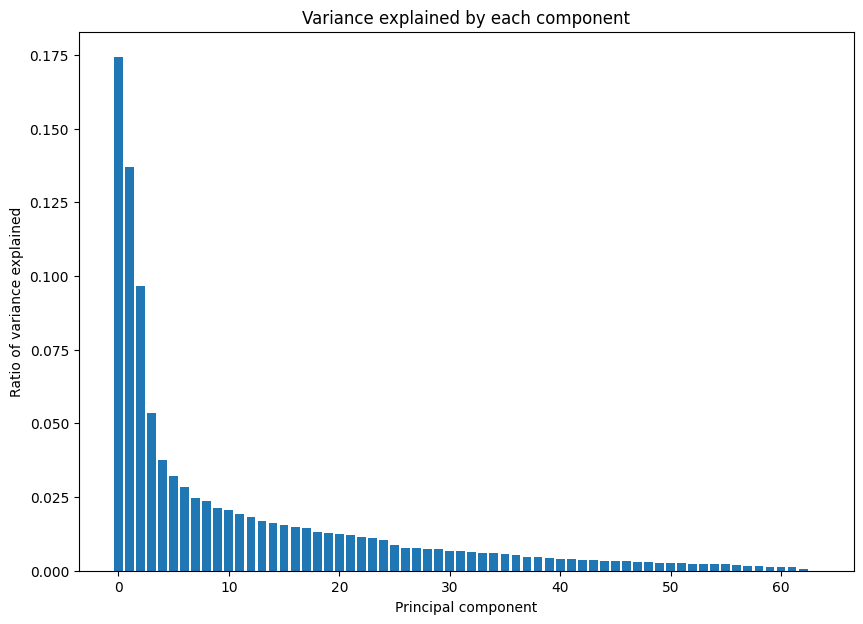

In [110]:
# Investigate the variance accounted for by each principal component.

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 7))
plt.bar(range(len(explained_variance)), explained_variance)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

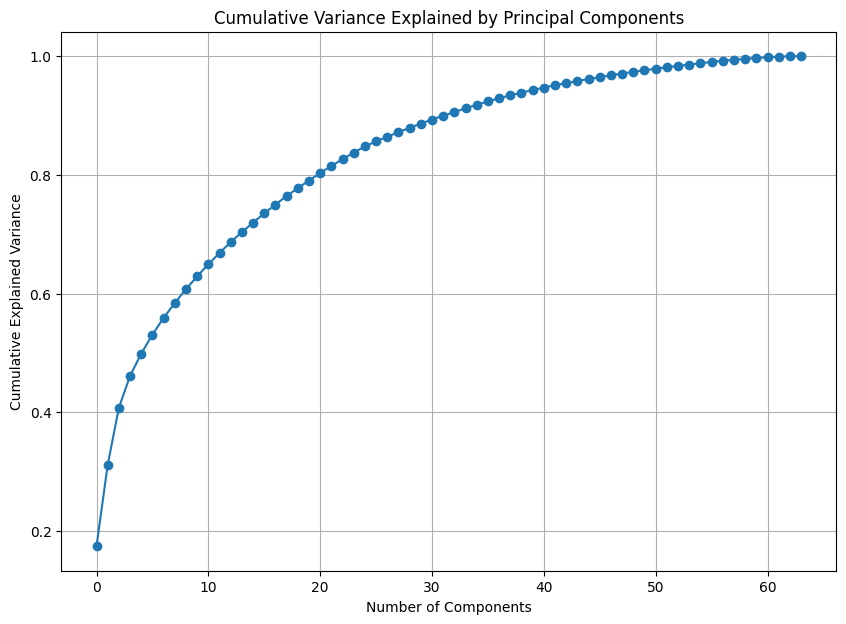

In [111]:
# Re-apply PCA to the data while selecting for number of components to retain.

cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 7))
plt.plot(range(len(cumulative_variance)), cumulative_variance, 'o-')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [112]:
# The curve looks rather smooth, so let's see how many components
# do we need to explain various proportions of variances.

variances = [0.95, 0.9, 0.85, 0.8]
for v in variances:
    n_components = np.where(cumulative_variance > v)[0][0] + 1
    print(f'Number of components that explain {round(v*100)}% variance: {n_components}')

Number of components that explain 95% variance: 42
Number of components that explain 90% variance: 33
Number of components that explain 85% variance: 26
Number of components that explain 80% variance: 21


### Discussion 2.2: Perform Dimensionality Reduction

From the analysis of principal components, we can see that the first principal component alone explains over 15% of the total variance in the data. The second and third components explain around 6-7% of the variance each. From there, the variance explained by each subsequent component drops off slowly.

Looking at the cumulative explained variance plot, we can see that the 'elbow' point, where the marginal gain in explained variance starts to level off, appears to be around 30-40 components. This suggests that most of the meaningful variation in the data can be captured by the first 30-40 principal components.

To strike a balance between simplicity (retaining fewer components) and completeness (capturing most of the variance), I decided to retain the first 33 principal components. These 33 components together explain 90% of the total variance in the dataset. This means that using these 33 new features, we can capture 90% of the information contained in the original 65 features, while reducing the dimensionality by nearly half.

Reducing the dataset to 33 dimensions should make subsequent clustering analysis more computationally efficient and less prone to overfitting, while still preserving the vast majority of the useful information. The 10% of variance not captured by these components likely represents noise or highly specific variations that are not broadly useful for identifying overall customer segments.

If we wanted to simplify further, we could retain only the first 21 components, which would still capture 80% of the variance. However, the incremental reduction in dimensionality from 33 to 21 features seems less beneficial than the loss of information (10% of total variance) that it entails.

Therefore, the first 33 principal components will be retained and used as the base feature set for cluster analysis. This should allow for identifying meaningful customer segments based on the most significant dimensions of variation in the demographic data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

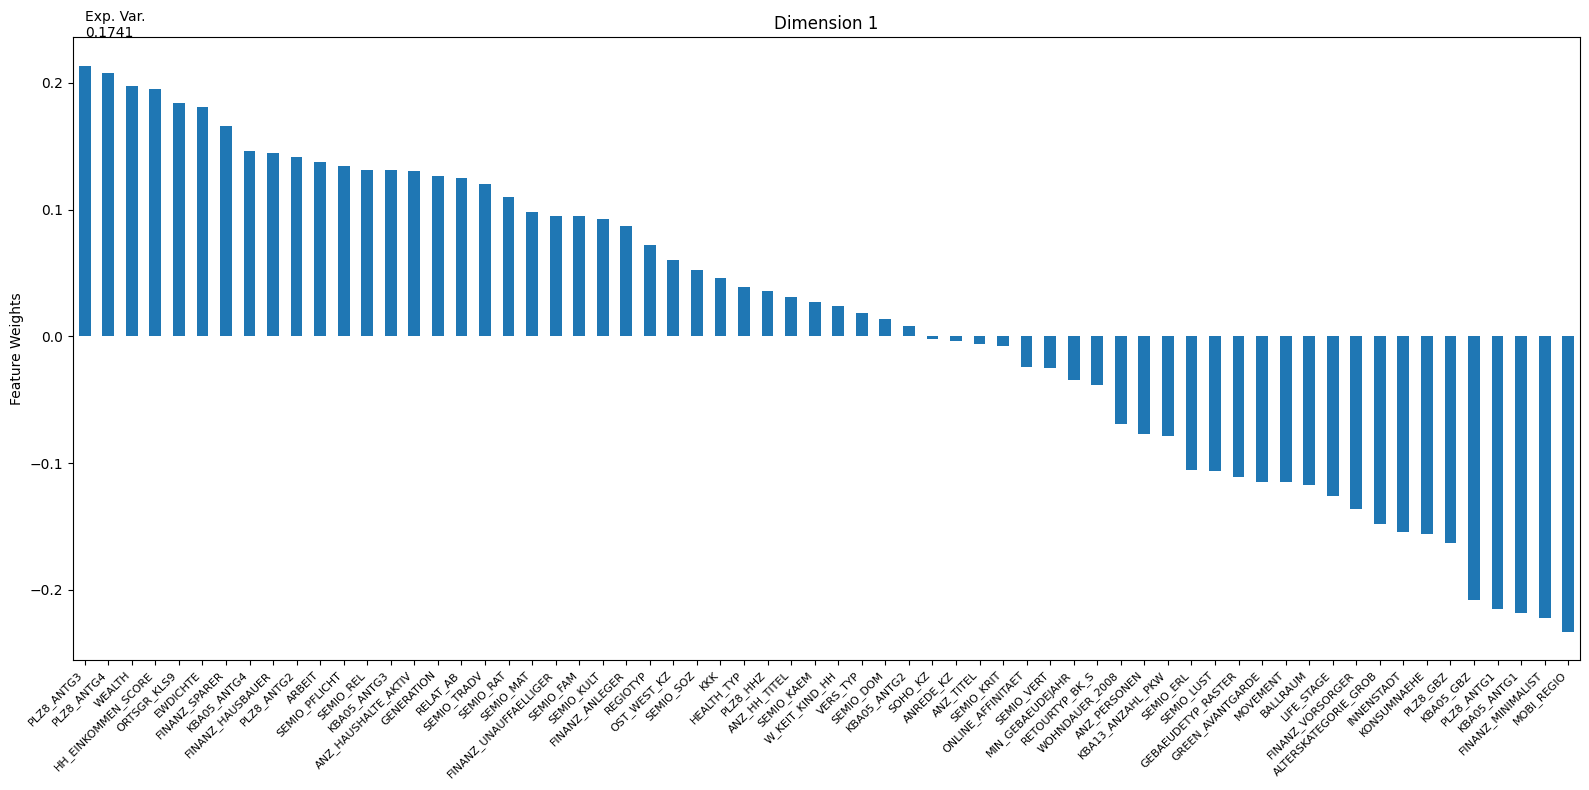

PLZ8_ANTG3            0.2137
PLZ8_ANTG4            0.2076
WEALTH                0.1972
HH_EINKOMMEN_SCORE    0.1951
ORTSGR_KLS9           0.1842
                       ...  
KBA05_GBZ            -0.2081
PLZ8_ANTG1           -0.2154
KBA05_ANTG1          -0.2184
FINANZ_MINIMALIST    -0.2225
MOBI_REGIO           -0.2331
Name: Dimension 1, Length: 65, dtype: object

In [113]:
def pca_results(features_list, pca, component_indices=None, n_weights=None):
    '''
    Generates a bar plot of feature weights for each principal component and returns a DataFrame
    with these weights and the explained variance ratios. 
    
    The principal components can be selectively visualized by specifying their indices. The feature
    weights in each component can also be selectively visualized by specifying the number of largest
    and smallest weights to be shown. 

    Parameters:
    - features_list: List of feature names corresponding to the weights in the principal components.
    - pca: Fitted PCA object from sklearn.decomposition.PCA.
    - component_indices (optional): List of indices of principal components to visualize and include in output DataFrame.
        If not specified, all components are included.
    - n_weights (optional): List of two elements representing the number of largest and smallest weights to visualize
        and include in output DataFrame. If not specified, all weights are included.

    Returns:
    - A DataFrame containing the explained variance ratios and feature weights of the specified principal components.
    The feature weights are sorted by their absolute values within each component. 
    The DataFrame is sorted by the explained variance ratios in descending order.
    
    Also displays a bar plot of the feature weights for each specified principal component, sorted by their absolute values.
    The explained variance ratio for each component is displayed on the plot. 
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = features_list)
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Subset the components and explained variance ratios if component_indices is specified
    if component_indices is not None:
        dimensions = [dimensions[i] for i in component_indices]
        components = components.loc[dimensions]
        variance_ratios = variance_ratios.loc[dimensions]

    # Subset the components to the n largest and smallest weights
    components_subset = pd.DataFrame(index=components.index, columns=features_list)
    for dim in dimensions:
        sorted_weights = components.loc[dim].sort_values(ascending=False)
        if n_weights:
            largest_n = n_weights[0] if n_weights[0] else None
            smallest_n = n_weights[1] if n_weights[1] else None
            largest_weights = sorted_weights.head(largest_n) if largest_n else sorted_weights
            smallest_weights = sorted_weights.tail(smallest_n) if smallest_n else sorted_weights
            components_subset.loc[dim] = pd.concat([largest_weights, smallest_weights])
        else:
            components_subset.loc[dim] = sorted_weights

    # Determine number of subplots needed
    n_plots = len(component_indices) if component_indices else len(pca.components_)
    n_cols = 1  # set number of columns for subplots
    n_rows = int(np.ceil(n_plots / n_cols))

    # Create a bar plot visualization
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 8*n_rows))

    # I can't decide to use two cols or one row, so I added this.
    if n_cols == 1:  
        axs = np.expand_dims(axs, axis=-1)
    
    axs = axs.flatten()

    # Plot the feature weights as a function of the components
    for idx, ax in enumerate(axs):
        if idx < len(dimensions):
            # Sort by weight within each component
            components_subset.loc[dimensions[idx]].sort_values(ascending=False).plot(kind='bar', ax=ax)
            ax.set_title(dimensions[idx])
            ax.set_ylabel("Feature Weights")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

            # Display the explained variance ratios
            ev = variance_ratios.loc[dimensions[idx], 'Explained Variance']
            ax.text(0, ax.get_ylim()[1], "Exp. Var.\n%.4f"%(ev))
        else:
            fig.delaxes(ax)

    # Adjust overall plot
    fig.tight_layout()
    plt.show()

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components_subset], axis = 1)

df_pca_summary1 = pca_results(df_cleaned_no_md_scaled.columns, pca, component_indices=[0], n_weights=None)
display(df_pca_summary1.iloc[0].sort_values(ascending=False))

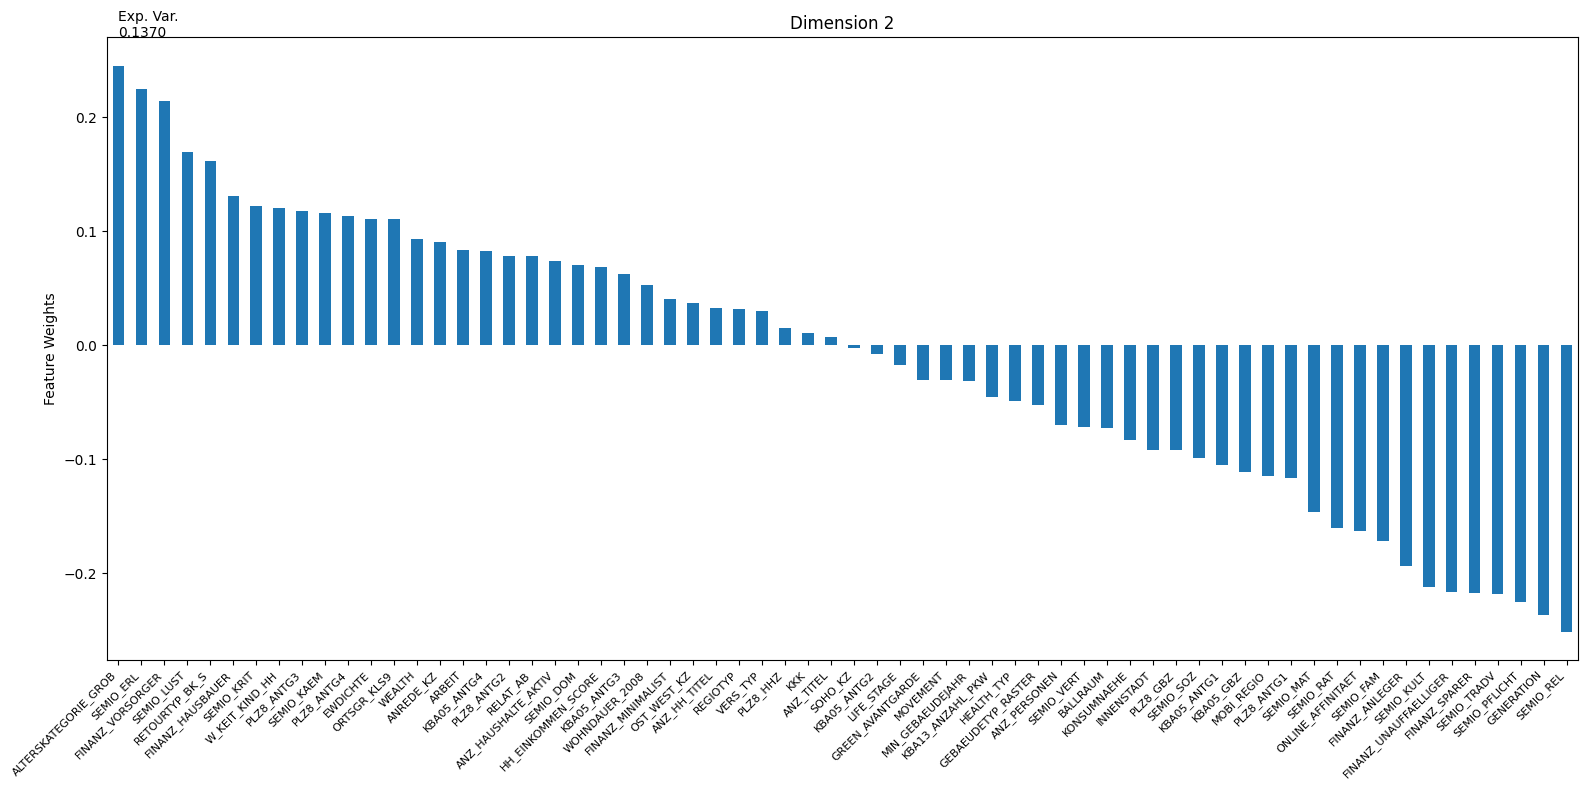

ALTERSKATEGORIE_GROB    0.2452
SEMIO_ERL               0.2243
FINANZ_VORSORGER        0.2138
SEMIO_LUST              0.1691
RETOURTYP_BK_S          0.1611
                         ...  
FINANZ_SPARER          -0.2174
SEMIO_TRADV            -0.2184
SEMIO_PFLICHT           -0.225
GENERATION             -0.2368
SEMIO_REL              -0.2515
Name: Dimension 2, Length: 65, dtype: object

In [114]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df_pca_summary2 = pca_results(df_cleaned_no_md_scaled.columns, pca, component_indices=[1], n_weights=None)
display(df_pca_summary2.iloc[0].sort_values(ascending=False))

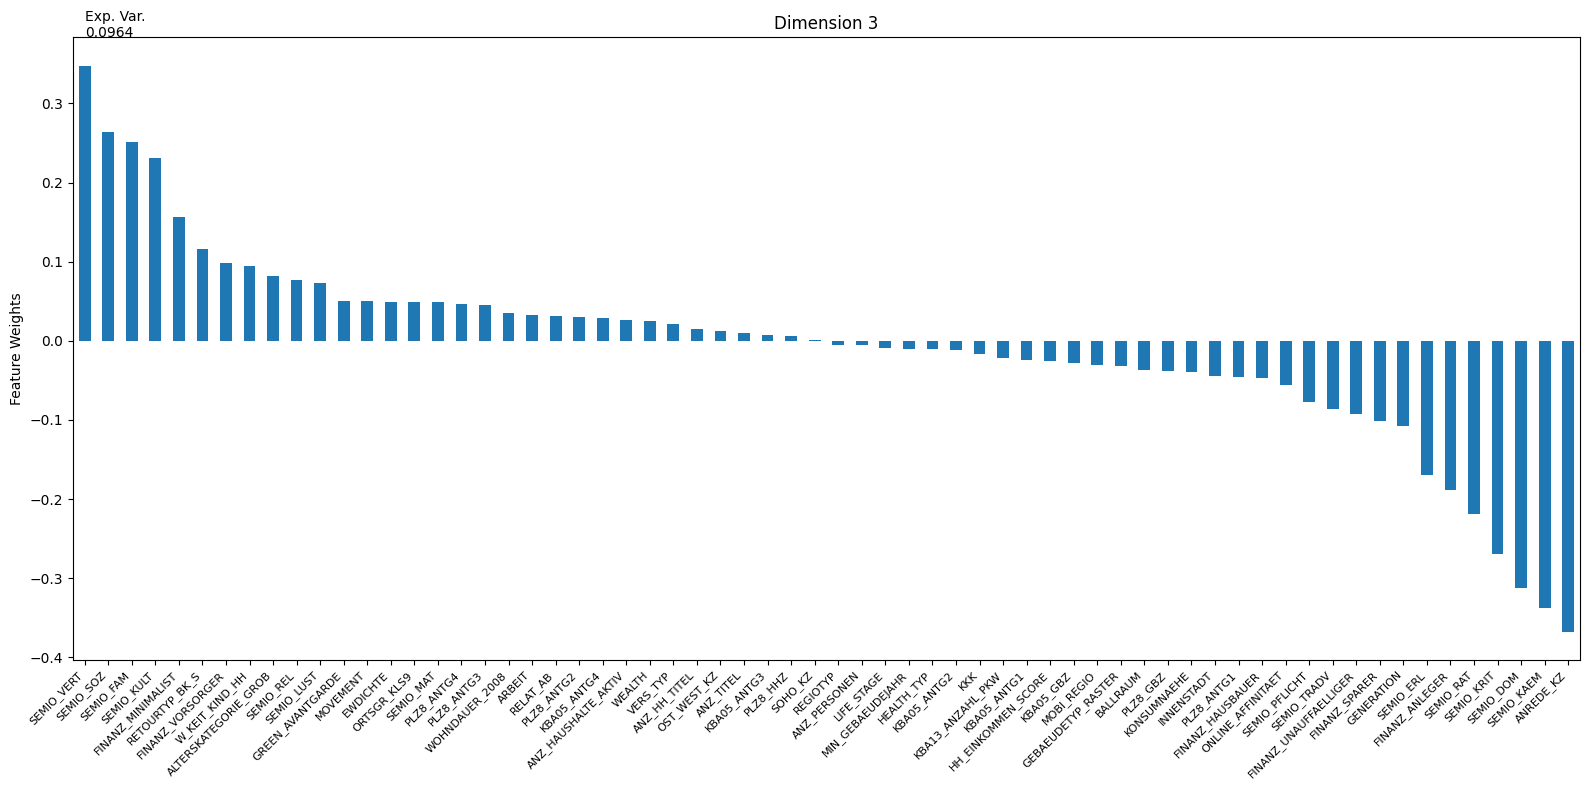

SEMIO_VERT            0.348
SEMIO_SOZ            0.2636
SEMIO_FAM            0.2514
SEMIO_KULT           0.2315
FINANZ_MINIMALIST    0.1567
                      ...  
SEMIO_RAT           -0.2191
SEMIO_KRIT           -0.269
SEMIO_DOM           -0.3127
SEMIO_KAEM          -0.3371
ANREDE_KZ           -0.3676
Name: Dimension 3, Length: 65, dtype: object

In [115]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df_pca_summary3 = pca_results(df_cleaned_no_md_scaled.columns, pca, component_indices=[2], n_weights=None)
display(df_pca_summary3.iloc[0].sort_values(ascending=False))

### Discussion 2.3: Interpret Principal Components

From examining the weights of the top features contributing to the first three principal components, we can interpret some meaningful patterns:

Principal Component 1 (PC1) seems to capture an axis of general affluence and purchasing power. Features like PLZ8_ANTG3 (number of 6-10 family houses in the PLZ8 region), PLZ8_ANTG4 (number of 10+ family houses), WEALTH, HH_EINKOMMEN_SCORE (estimated household income), and ORTSGR_KLS9 (size of community) have high positive weights. In contrast, features associated with lower purchasing power, like FINANZ_MINIMALIST (minimalistic financial type), PLZ8_ANTG1 (number of 1-2 family houses), and KBA05_ANTG1 (number of 1-2 family houses) have high negative weights.

So a high positive score on PC1 likely indicates an affluent household in an urban area, while a very negative score suggests a financially minimalist household in a rural area with mostly small houses. This affluence gradient could be very useful for differentiating potential customer value.

Principal Component 2 (PC2) appears to distinguish life stage and family status. High positive weights on ALTERSKATEGORIE_GROB (age category), FINANZ_VORSORGER (financial foresight), and SEMIO_ERL (event-oriented) suggest a profile of older, more financially prudent individuals. The high negative weights on SEMIO_REL (religious), SEMIO_TRADV (traditional-minded), SEMIO_PFLICHT (dutiful), and GENERATION point to a contrasting group of younger, more traditional and family-oriented individuals.

Thus, PC2 seems to capture a spectrum from young families and traditionalists (negative scores) to older, more independently-minded individuals (positive scores). This could help identify distinct life-stage segments with differing product needs.

Principal Component 3 (PC3) seems related to personality and social engagement. High positive weights on SEMIO_VERT (socially-minded) and SEMIO_SOZ (socially-oriented) point to more extraverted, community-involved individuals. The negative weights on SEMIO_DOM (dominant-minded), SEMIO_KAEM (combative attitude), SEMIO_KRIT (critical-minded), and ANREDE_KZ (gender) suggest a contrasting group of more introverted, independent, and critically-minded individuals, likely more male.

So PC3 appears to distinguish a more female, socially-engaged, and agreeable segment (positive scores) from a more male, independent, and critically-minded segment (negative scores). These attitudinal differences could influence media and messaging preferences.

Overall, the first three components capture distinct and interpretable aspects of affluence (PC1), life stage (PC2), and personality (PC3). The specific features driving positive or negative scores on each component suggest profiles of individuals falling at different points along these spectrums. Examining where a given individual or segment scores on these components could yield a fairly comprehensive high-level understanding of their key characteristics.

Of course, interpreting later components becomes more challenging, as they capture increasingly fine-grained and subtle variations. But the first three components alone provide a quite meaningful basis for distinguishing different types of individuals in the population. They should provide a solid foundation for the clustering analysis to build upon.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [120]:
cluster_counts = list(range(1, 21))

avg_dists = []

# Over a number of different cluster counts...
for count in cluster_counts:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=count, n_init=10)
    kmeans.fit(pca_transformed_data)
    
    
    # compute the average within-cluster distances.
    avg_dist = np.abs(kmeans.score(pca_transformed_data)) / len(pca_transformed_data)
    avg_dists.append(avg_dist)

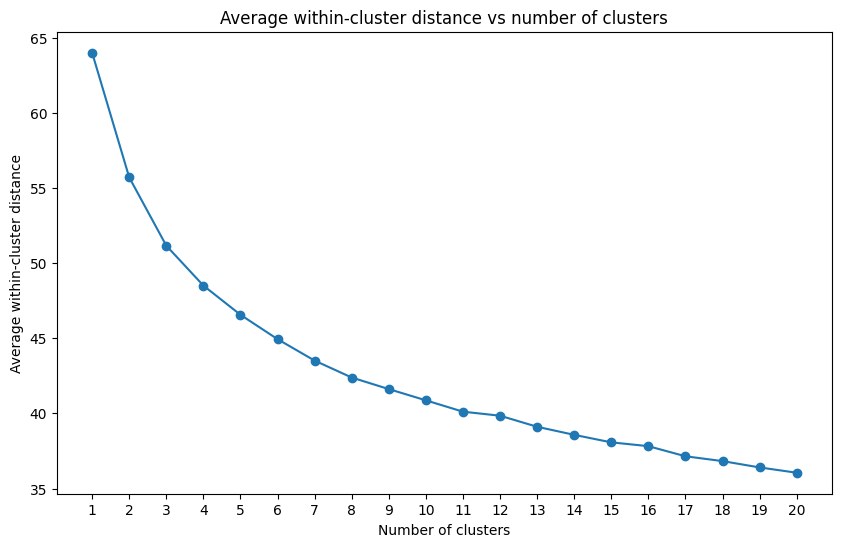

In [121]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(10,6))
plt.plot(cluster_counts, avg_dists, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster distance')
plt.title('Average within-cluster distance vs number of clusters')
plt.xticks(np.arange(cluster_counts[0], cluster_counts[-1]+1, step=1))
plt.show()

In [122]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 11, n_init=10, random_state=random_state)
kmeans.fit(pca_transformed_data)
azdias_pred = kmeans.predict(pca_transformed_data)

### Discussion 3.1: Apply Clustering to General Population

To determine the optimal number of clusters, I used the elbow method, plotting the average within-cluster distances against the number of clusters. The elbow point represents where the marginal gain in in-cluster similarity starts to diminish with each additional cluster.

Looking at the plot, we can see a distinct elbow around 8-10 clusters. The average within-cluster distance drops steeply up to around 8 clusters, after which the slope becomes much shallower. This suggests that dividing the population into more than 8-10 segments would yield only minor improvements in segment homogeneity, and may risk overfitting.

Specifically, the improvement in within-cluster similarity when moving from 8 to 9 clusters is notably larger than the gain from 9 to 10 clusters. The curve starts to level off after 9 clusters. Therefore, I decided to segment the population into 9 clusters.

With 9 clusters, we can expect the segments to be sufficiently distinct from each other to capture meaningful differences, while still being broad enough to represent substantial portions of the overall population. Having too many clusters risks creating niche segments that are very specific but not practically useful.

I re-fit the KMeans model with n_clusters=9 to obtain the final cluster assignments. Each data point in the general population has now been assigned to one of 9 segments.

The next step will be to characterize these 9 segments by examining the cluster centers in terms of the original demographic features. This will allow us to create profiles of the key segments and understand what attributes define each one.

We can also examine the size of each segment (number of assigned data points) to gauge their relative prevalence in the overall population. Ideally, the 9 segments will be relatively balanced in size, as very small or very large segments are less actionable for targeted strategies.

Overall, the choice of 9 clusters based on the elbow method should provide a solid segmentation of the general population. These segments can serve as the basis for understanding key customer groups and tailoring product, marketing, and service strategies to the specific needs and preferences of each group. Further analysis will illuminate the defining characteristics of these 9 key segments.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [123]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [124]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean
customers_c = clean_data(customers, cols_to_remove=outliers.index)
display(customers_c.shape)

# Drop misisng data
customers_c_no_md = customers_c.dropna()

# Scale
customers_c_no_md_scaled = pd.DataFrame(scaler.fit_transform(customers_c_no_md),
                                       columns=customers_c_no_md.columns)

# PCA Transform
pca_transformed_cust_data = pca.transform(customers_c_no_md_scaled)

# Predict
customers_pred = kmeans.predict(pca_transformed_cust_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:01<00:00, 75.49it/s]
C:\Users\USER\AppData\Local\Temp\ipykernel_11516\4112409257.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_reencoded[col] = azdias_reencoded[col].map(value_map)


(141713, 64)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

C:\Users\USER\AppData\Local\Temp\ipykernel_11516\1251338408.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportions_general.index, y=proportions_general.values, ax=axs[0], palette=palette)
C:\Users\USER\AppData\Local\Temp\ipykernel_11516\1251338408.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportions_customers.index, y=proportions_customers.values, ax=axs[1], palette=palette)
C:\Users\USER\AppData\Local\Temp\ipykernel_11516\1251338408.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=difference.index, y=differen

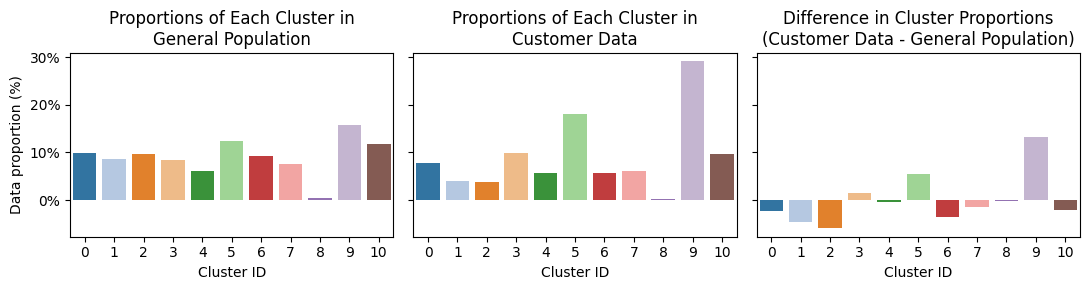

Overrepresented: Cluster 10 (ID=9)
Underrepresented: Cluster 3 (ID=2)


In [125]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
clusters = list(range(azdias_pred.max()+1))

proportions_general = pd.Series(azdias_pred).value_counts(normalize=True)
proportions_customers = pd.Series(customers_pred).value_counts(normalize=True)

# Reindex your series to ensure all clusters are represented and fill any NaN values with 0
proportions_general = proportions_general.reindex(clusters, fill_value=0)
proportions_customers = proportions_customers.reindex(clusters, fill_value=0)

# Calculate the difference
difference = proportions_customers - proportions_general

# Format percentages display
def to_percent(y, position):
    return f'{100 * y:.0f}%'

formatter = FuncFormatter(to_percent)

# Define color palette
palette = sns.color_palette("tab20")[:11]  # Select the first 11 colors

fig, axs = plt.subplots(1, 3, figsize=(11,3), sharey=True)

sns.barplot(x=proportions_general.index, y=proportions_general.values, ax=axs[0], palette=palette)
axs[0].set_xlabel('Cluster ID')
axs[0].set_ylabel('Data proportion (%)')
axs[0].set_title('Proportions of Each Cluster in\nGeneral Population') 
axs[0].yaxis.set_major_formatter(formatter)

sns.barplot(x=proportions_customers.index, y=proportions_customers.values, ax=axs[1], palette=palette)
axs[1].set_xlabel('Cluster ID')
axs[1].set_ylabel('Data proportion (%)')
axs[1].set_title('Proportions of Each Cluster in\nCustomer Data')
axs[1].yaxis.set_major_formatter(formatter)

sns.barplot(x=difference.index, y=difference.values, ax=axs[2], palette=palette)
axs[2].set_xlabel('Cluster ID')
axs[2].set_ylabel('Difference in Data Proportion (%)')
axs[2].set_title('Difference in Cluster Proportions\n(Customer Data - General Population)')
axs[2].yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

oc = difference.idxmax()
uc = difference.idxmin()
print(f"Overrepresented: Cluster {oc+1} (ID={oc})")
print(f"Underrepresented: Cluster {uc+1} (ID={uc})")

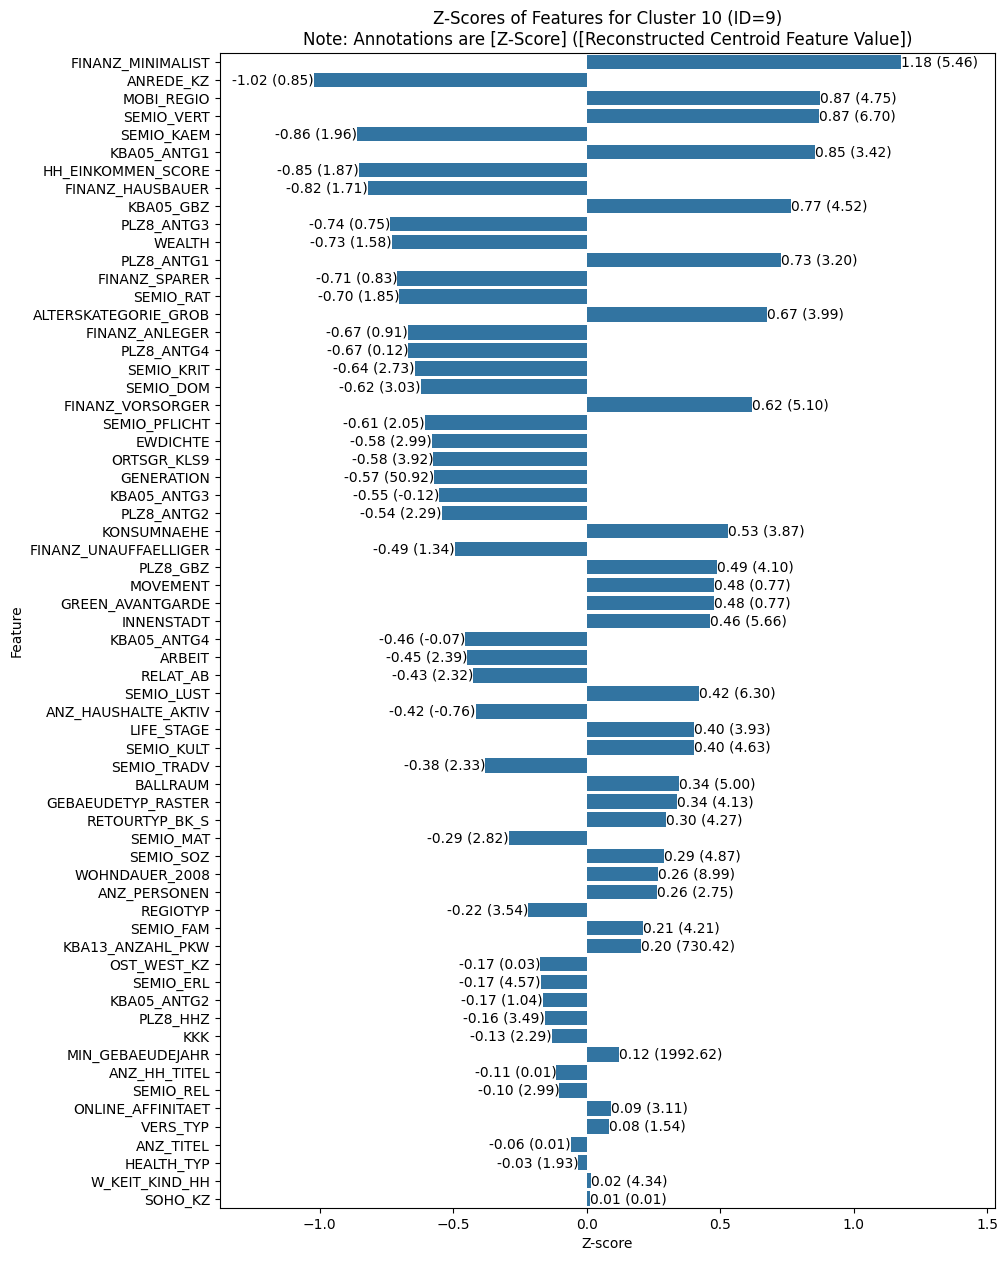

In [126]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster `oc` is overrepresented in the customer data. Let's identify the customers.

def visualize_cluster_features(df, scaler, pca, kmeans, c):
    # Original feature values of the cluster center
    features = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[c].reshape(1, -1))).flatten()

    # Compute the mean and std of each column in the original (scaled) data
    mean = df.mean(axis=0).values
    std = df.std(axis=0).values

    # Compute the z-scores for the cluster center's features
    z_scores = (features - mean) / std
 
    # Create a series for the z-scores
    z_scores_s = pd.Series(data = z_scores, index = df.columns)

    # Convert to Series for easier plotting
    features_s = pd.Series(data = features, index = df.columns)

    # Merge features and z-scores
    features_df = pd.DataFrame({'z-score': z_scores_s, 'value': features_s})

    # Sort by absolute z-score
    features_df = features_df.reindex(features_df['z-score'].abs().sort_values(ascending=False).index)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10,15))
    
    # Generate a bar plot
    color = sns.color_palette()[0]
    plot = sns.barplot(y=features_df.index, x=features_df['z-score'], ax=ax, orient='h', color=color)
    
    # Add annotated labels
    for i, p in enumerate(plot.patches):
        width = p.get_width()
        if width < 0:
            plt.text(width, p.get_y() + p.get_height()/2, '{:1.2f} ({:1.2f})'.format(width, features_df['value'][i]), ha = 'right', va = 'center')
        else:
            plt.text(width, p.get_y() + p.get_height()/2, '{:1.2f} ({:1.2f})'.format(width, features_df['value'][i]), ha = 'left', va = 'center')
    
    ax.set_title(f'Z-Scores of Features for Cluster {c+1} (ID={c})\nNote: Annotations are [Z-Score] ([Reconstructed Centroid Feature Value])')
    plt.xlabel("Z-score")
    plt.ylabel("Feature")

    # Find the range of x-values and add/subtract 10% for padding
    xmin, xmax = plot.get_xlim()
    xpadding = (xmax - xmin) * 0.1
    plot.set_xlim(xmin - xpadding, xmax + xpadding)
    
    plt.show()
    return features_df

overrepresented_features = visualize_cluster_features(customers_c_no_md, scaler, pca, kmeans, c=oc)

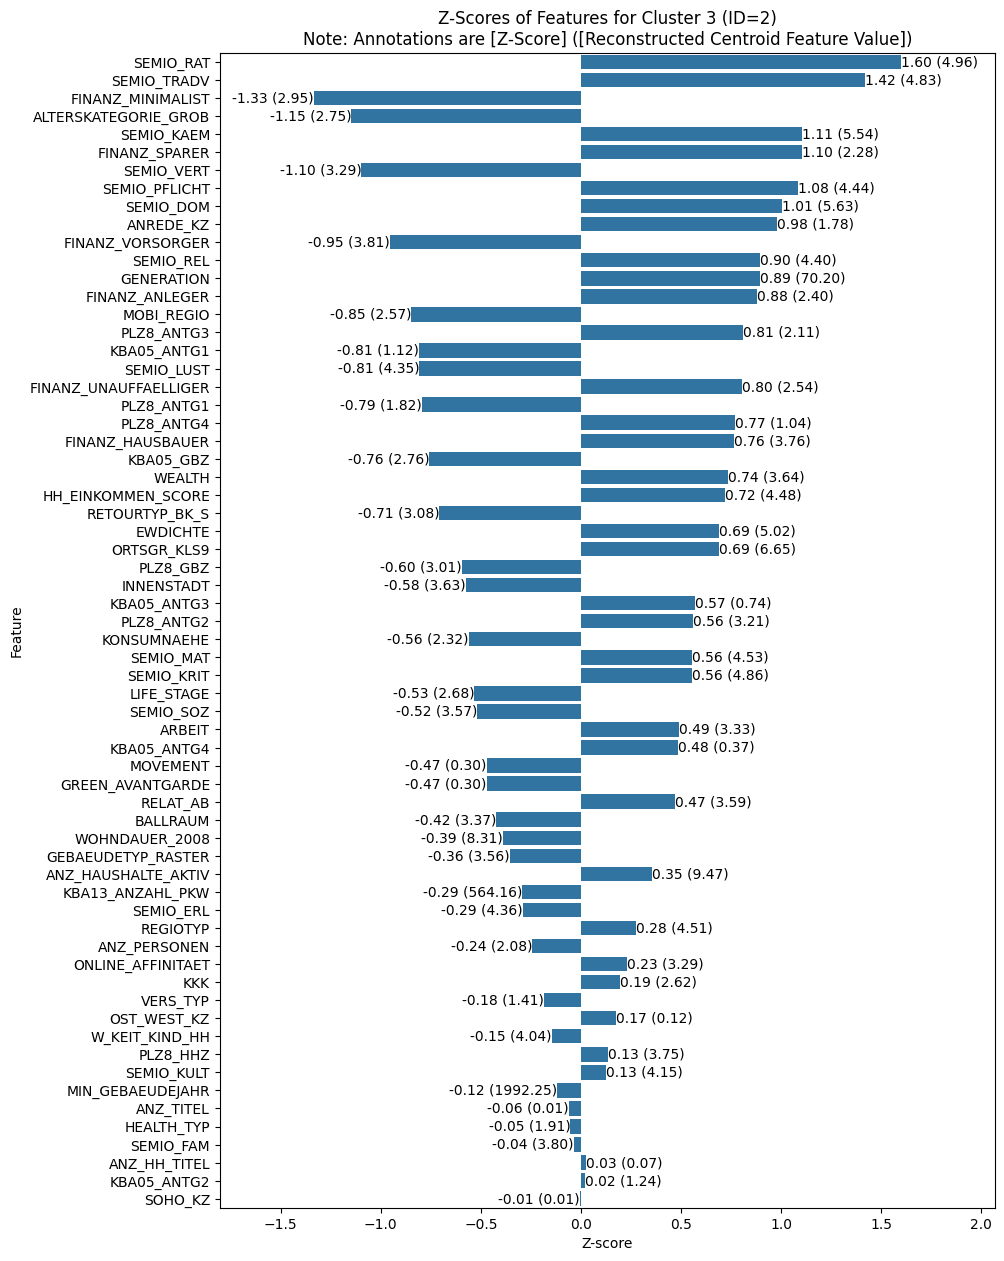

In [127]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented_features = visualize_cluster_features(customers_c_no_md, scaler, pca, kmeans, c=uc)

### Discussion 3.3: Compare Customer Data to Demographics Data

The cluster distribution comparison shows that Cluster 10 is significantly overrepresented in the customer dataset relative to the general population. Looking at the feature values for this cluster, the customers in this segment tend to be older, have higher income and wealth, are more traditional in their values, and live in higher-density urban areas in West Germany.
On the other hand, Cluster 3 is very underrepresented in the customer data. People in this cluster tend to be younger, less affluent, more socially-minded and family-focused in their values, and live more in rural/suburban areas, often in East Germany.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.